## Improving Pretext Task

By this point we've implemented a basic pretext task and have validated that it improved our network's performance on two downstream tasks.

Now we'd like to play around with altering the pretext task in the hope that it will improve downstream performance further. In this notebook, we'll include both the pretext task training and the downstream task training.

In [3]:
import json
import torch

import numpy as np

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

In [4]:
images_path = untar_data(URLs.IMAGEWANG_160)
images_path = images_path/'unsup'

In [5]:
# We create this dummy class in order to create a transform that ONLY operates on images of this type
# We will use it to create all input images
class PILImageInput(PILImage): pass

class RandomCutout(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, min_n_holes=5, max_n_holes=10, min_length=5, max_length=50, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length
        

    def encodes(self, x:PILImageInput):
        """
        Note that we're accepting our dummy PILImageInput class
        fastai2 will only pass images of this type to our encoder. 
        This means that our transform will only be applied to input images and won't
        be run against output images.
        """
        
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
        pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        h,w = pixels.shape[:2]

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            pixels[y1:y2, x1:x2, :] = 0
            
        return Image.fromarray(pixels, mode='RGB')

In [6]:
data = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [18]:
databunch = data.databunch(images_path, 
                           bs=10, 
                           item_tfms=[RandomResizedCrop(160), RandomCutout()], 
                           batch_tfms=[*aug_transforms(size=160, max_warp=0, max_rotate=0), Normalize.from_stats(*imagenet_stats)])
# HACK: We're predicting pixel values, so we're just going to predict an output for each RGB channel
databunch.vocab = ['R', 'G', 'B']

In [19]:
from fastai2.vision.learner import (model_meta, _default_meta, create_body, 
                                    ifnone, get_c, models, Learner, SequentialEx)

from fastcore.foundation import defaults, delegates
import torch.nn as nn
from fastai2.layers import NormType, in_channels, ResBlock
from fastai2.callback.hook import model_sizes

from fastai2.vision.models.unet import (_get_sz_change_idxs, hook_outputs, dummy_eval, ConvLayer, BatchNorm,
                                       UnetBlock, PixelShuffle_ICNR, ResizeToOrig, MergeLayer)

from fastai2.torch_core import apply_init, Module

In [20]:
class DynamicUnetNoSkipConnections(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_classes, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=NormType.Batch, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        #self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock_NoSkip(up_in_c, final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_classes, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
class UnetBlock_NoSkip(Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    @delegates(ConvLayer.__init__)
    def __init__(self, up_in_c, final_div=True, blur=False, act_cls=defaults.activation,
                 self_attention=False, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, act_cls=act_cls, norm_type=norm_type)
        #self.bn = BatchNorm(x_in_c)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type,
                               xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = act_cls()
        apply_init(nn.Sequential(self.conv1, self.conv2), init)
        
    def forward(self, up_in):
        #s = self.hook.stored
        up_out = self.shuf(up_in) #upsample
#        ssh = s.shape[-2:]
#         if ssh != up_out.shape[-2:]:
#             up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out], dim=1))
        return self.conv2(self.conv1(cat_x))



In [21]:
def create_unet_no_skip_connections(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, n_out=None, **kwargs):
    "Build a unet learner from `dls` and `arch`"
    if config is None: config = unet_config()
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, pretrained, ifnone(cut, meta['cut']))
    size = dls.one_batch()[0].shape[-2:]
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    
    model = DynamicUnetNoSkipConnections(body, n_out, size, **config)
    
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn    

In [28]:
loss = MSELoss()
learn = create_unet_no_skip_connections(databunch, resnet34, pretrained=False, config=unet_config(), loss_func=loss)

epoch,train_loss,valid_loss,time
0,0.174730,0.163613,00:42
1,0.147540,0.141612,00:43
2,0.135541,0.116571,00:42
3,0.132457,0.107914,00:43
4,0.121174,0.305824,00:41
5,0.114934,0.091418,00:42
6,0.114693,0.107100,00:41
7,0.112551,0.096255,00:41
8,0.113201,0.090241,00:42
9,0.110691,0.180264,00:40


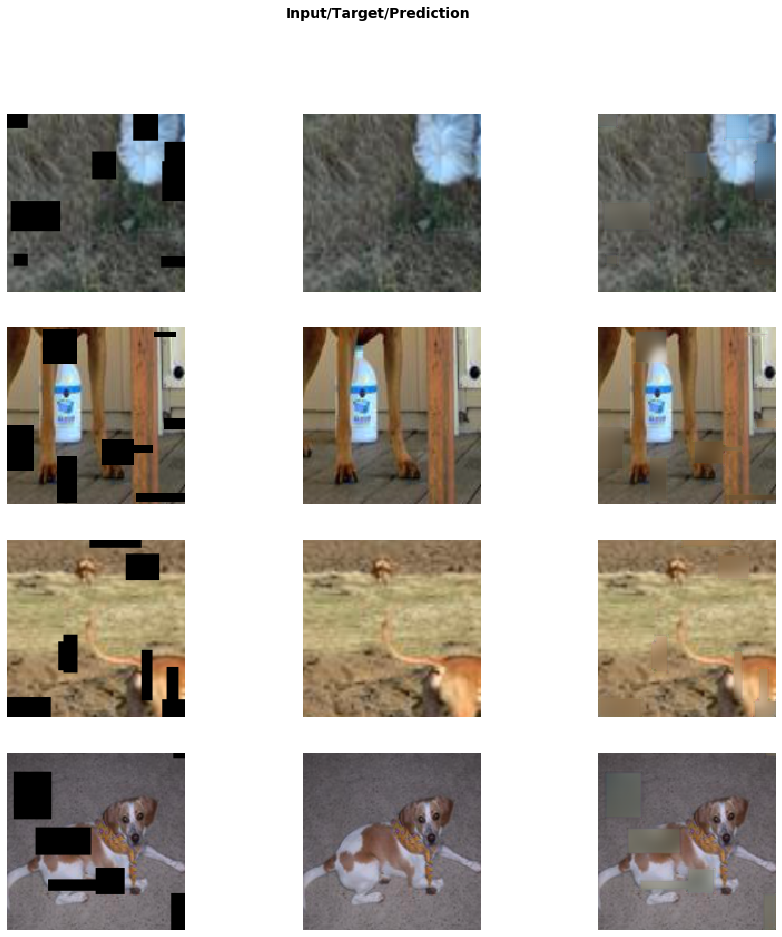

In [29]:
learn.fit_one_cycle(60, 10e-3)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

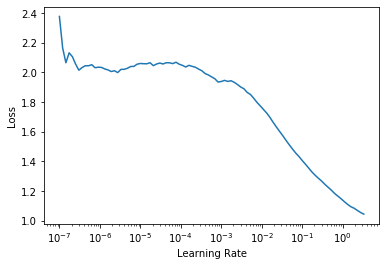

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.204688,0.591319,00:39
1,0.165836,0.754127,00:41
2,0.146147,0.311586,00:40
3,0.150058,0.168457,00:40
4,0.157718,0.157174,00:40
5,0.146742,0.162570,00:40
6,0.152211,0.177512,00:40
7,0.140750,0.491791,00:40
8,0.147135,0.182427,00:40
9,0.131969,0.243943,00:41


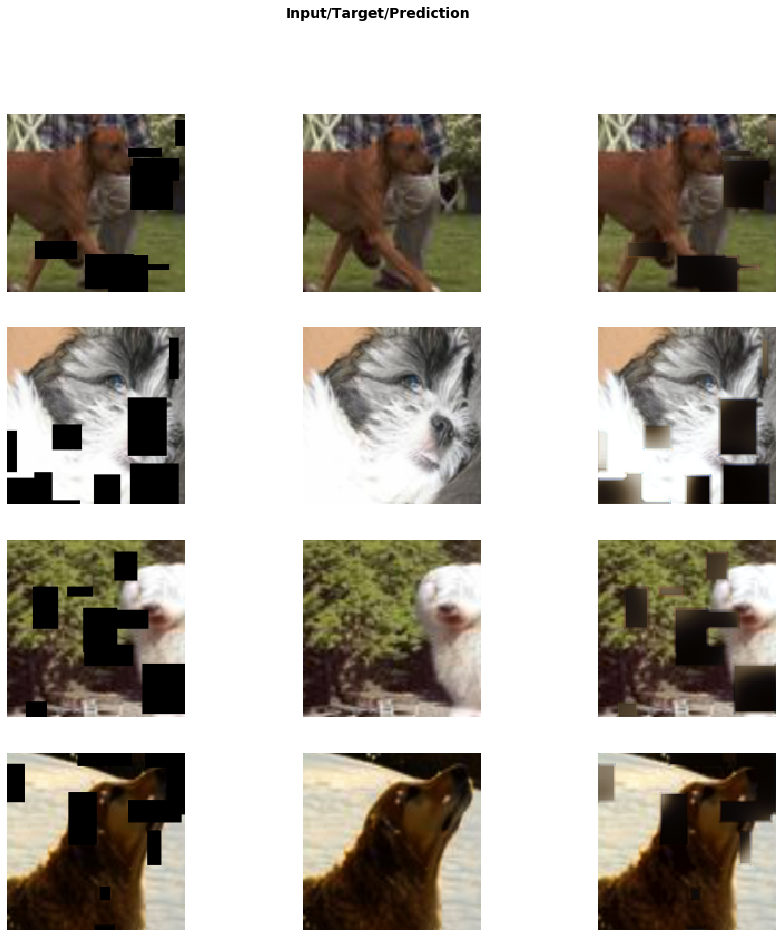

In [27]:
learn.fit_one_cycle(30, 10e-2)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))